In [1]:
#!/usr/bin/python3.8
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import seaborn as sns
import matplotlib
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.signal import find_peaks
# import tensorflow as tf
# from sklearn.model_selection import train_test_split


# %matplotlib notebook

In [448]:
# ================= CONSTANTS =================
PMT_PULSE_LENGTH = 1500  # Sample lenght of a typical pulse
SAMPLES_BEFORE_PEAK = 4  # Samples to store before peak detection. MUST BE SMALLER THAN 8

In [3]:
# df=pd.read_csv("../data_Cs137/20210715_173047/20210715_173047_0.csv", index_col=0)
df=pd.read_csv("/mnt/hdd500/cernbox/Na22_v4_t100_s65530_hv2000_noPb_v2/20210830/woPb_split/20210830_124918/Na22_v4_t100_noPb_joined.csv", index_col=0)

In [5]:
df

0    1    2    3    4    5    6    7    8    9  ...  13600  13601  \
0      138  137  138  138  138  138  138  137  137  138  ...    137    138   
1      137  137  137  137  137  138  137  137  137  138  ...    137    137   
2      138  137  138  137  137  138  138  137  137  138  ...    138    138   
3      137  137  137  137  137  137  137  135  137  137  ...    137    138   
4      137  138  137  137  137  138  137  135  138  138  ...    138    138   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...    ...   
65525  137  137  137  136  137  137  136  136  137  137  ...    137    137   
65526  138  138  137  137  137  138  137  138  138  138  ...    138    136   
65527  137  137  137  137  137  136  137  136  137  137  ...    137    137   
65528  122  138  131  132  138  138  137  137  138  137  ...    137    138   
65529  119  137  132  135  137  137  137  136  136  137  ...    137    136   

       13602  13603  13604  13605  13606  13607  13608  13609  
0        138    138    138    137    137    137    138    125  
1        137    137    137    137    136    137    137    116  
2        138    137    137    137    136    137    138    109  
3        138    136    137    136    136    137    137    114  
4        138    138    138    138    137    137    137    115  
...      ...    ...    ...    ...    ...    ...    ...    ...  
65525    137    137    138    137    137    137    136    137  
65526    138    138    138    138    137    138    138    137  
65527    137    136    137    137    137    137    136    137  
65528    138    137    138    138    138    131    138    126  
65529    137    137    137    137    136    127    137    125  

[65530 rows x 13610 columns]

# Peak detection

In [6]:
def pkdetect(x, thr=100, pkh=10):
    peak=[]
    lmax=0
    imax=0
    count=0
    for i in range(1,len(x)):
        if x[i] <= thr:
            pass
        elif x[i] > lmax:
            imax=i
            lmax=x[i]
        elif ((lmax-x[i-1]) > pkh) and (x[i]-x[i-1])>0:
            peak.append(imax)
            lmax=0
        else:
            pass
            
    return peak

# Individual pulse isolation and area estimation

In [7]:
#Isolating individual pulses within a trace

def isolatePulses(singleTrace, peakIndexesList, pulseLength, samplesBeforePeak):
    singleTrace = singleTrace.tolist()
    i = 0 #Input pulse index
    outputPulseIndex = 0
    diffFromLastPeak = pulseLength #In order to classify the first pulse as a valid event
    isolatedPulses = [] #Output variable (list of pulse samples) that stores each valid pulse
    
    #Be sure to slide along the whole trace, avoiding short pulses located at the end
    while ((i < len(peakIndexesList)) and (peakIndexesList[i] <= len(singleTrace) - pulseLength)):
        #print("Diff from last peak: " + str(diffFromLastPeak))
        if(diffFromLastPeak >= pulseLength):
            lowerPulseRange = peakIndexesList[i] - samplesBeforePeak #Be sure to record some samples before peak
            upperPulseRange = lowerPulseRange + pulseLength #Store the whole pulse
            isolatedPulses.append([])
            isolatedPulses[outputPulseIndex].extend(singleTrace[lowerPulseRange:upperPulseRange])
            #print("OutputPulseIndex: " + str(outputPulseIndex))
            outputPulseIndex += 1
            diffFromLastPeak = 0
        i += 1
        if i < len(peakIndexesList):
            diffFromLastPeak += peakIndexesList[i] - peakIndexesList[i-1] #Check if peaks are distant enough
            
        else:
            break
    
    return isolatedPulses
        

In [8]:
#Isolating individual pulses within a trace using multithreading

def isolatePulsesMP(singleTrace, peakIndexesList, pulseLength, samplesBeforePeak, queue):
    singleTrace = singleTrace.tolist()
    i = 0 #Input pulse index
    outputPulseIndex = 0
    diffFromLastPeak = pulseLength #In order to classify the first pulse as a valid event
    isolatedPulses = [] #Output variable (list of pulse samples) that stores each valid pulse
    
    
    #Be sure to slide along the whole trace, avoiding short pulses located at the end
    while ((i < len(peakIndexesList)) and (peakIndexesList[i] <= len(singleTrace) - pulseLength)):
        #print("Diff from last peak: " + str(diffFromLastPeak))
        if(diffFromLastPeak >= pulseLength):
            lowerPulseRange = peakIndexesList[i] - samplesBeforePeak #Be sure to record some samples before peak
            upperPulseRange = lowerPulseRange + pulseLength #Store the whole pulse
            isolatedPulses.append([])
            isolatedPulses[outputPulseIndex].extend(singleTrace[lowerPulseRange:upperPulseRange])            
            #print("OutputPulseIndex: " + str(outputPulseIndex))
            outputPulseIndex += 1
            diffFromLastPeak = 0
        i += 1
        if i < len(peakIndexesList):
            diffFromLastPeak += peakIndexesList[i] - peakIndexesList[i-1] #Check if peaks are distant enough
            
        else:
            break
        
    queue.put(isolatedPulses[1:])
        

In [9]:
#Dataframe with individual pulses
dfPulses = pd.DataFrame(columns = [0])

In [10]:
df[df.columns[1]]

0        137
1        137
2        137
3        137
4        138
        ... 
65525    137
65526    138
65527    137
65528    138
65529    137
Name: 1, Length: 65530, dtype: int64

In [11]:
import multiprocessing as mp

THREADS = 24




mpQueues = [mp.Queue() for i in range(THREADS)]
nTraces = len(df.T)
# nTraces = 9
traceIdx = 0



# for i in range(0, nTraces, THREADS):
#     runningThreads = 0
#     for j in range(THREADS):
#         currentTraceIndex = i + j
#         if currentTraceIndex < nTraces:
#             runningThreads += 1
#             thisTrace = df[df.columns[currentTraceIndex]]
#             peaksList = pkdetect(thisTrace, 10, 10)
#             p = mp.Process(target = isolatePulsesMP, args = (thisTrace, peaksList, PMT_PULSE_LENGTH, SAMPLES_BEFORE_PEAK, mpQueues[j]))
#             p.start()
#             print("Processing trace " + str(currentTraceIndex + 1) + "/" + str(nTraces))
#     for k in range(runningThreads):
# #         print("Joining thread " + str(k+1) + "/" + str(runningThreads))
#         testList = []
#         testList.extend(mpQueues[k].get())
#         testList = pd.Series(testList)
#         for l in testList:
#             dfPulses[traceIdx] = l
#             traceIdx += 1
#         p.join()
        
# print("Done!")
        




for i in range(nTraces):
#     testList.append([])
    thisTrace = df[df.columns[i]]
    peaksList = pkdetect(thisTrace, 10, 10)
    individualPulses = isolatePulses(thisTrace, peaksList, PMT_PULSE_LENGTH, SAMPLES_BEFORE_PEAK)[1:]
    #print("Individual pulses: " + str(individualPulses))
    print("Processing trace " + str(i + 1) + "/" + str(nTraces))
    for j in individualPulses:
        #print("j: " + str(j))
        dfPulses[traceIdx] = j
        traceIdx += 1
print("Done!")

Processing trace 1/13610
Processing trace 2/13610
Processing trace 3/13610
Processing trace 4/13610
Processing trace 5/13610
Processing trace 6/13610
Processing trace 7/13610
Processing trace 8/13610
Processing trace 9/13610
Processing trace 10/13610
Processing trace 11/13610
Processing trace 12/13610
Processing trace 13/13610
Processing trace 14/13610
Processing trace 15/13610
Processing trace 16/13610
Processing trace 17/13610
Processing trace 18/13610
Processing trace 19/13610
Processing trace 20/13610
Processing trace 21/13610
Processing trace 22/13610
Processing trace 23/13610
Processing trace 24/13610
Processing trace 25/13610
Processing trace 26/13610
Processing trace 27/13610
Processing trace 28/13610
Processing trace 29/13610
Processing trace 30/13610
Processing trace 31/13610
Processing trace 32/13610
Processing trace 33/13610
Processing trace 34/13610
Processing trace 35/13610
Processing trace 36/13610
Processing trace 37/13610
Processing trace 38/13610
Processing trace 39/1

Processing trace 309/13610
Processing trace 310/13610
Processing trace 311/13610
Processing trace 312/13610
Processing trace 313/13610
Processing trace 314/13610
Processing trace 315/13610
Processing trace 316/13610
Processing trace 317/13610
Processing trace 318/13610
Processing trace 319/13610
Processing trace 320/13610
Processing trace 321/13610
Processing trace 322/13610
Processing trace 323/13610
Processing trace 324/13610
Processing trace 325/13610
Processing trace 326/13610
Processing trace 327/13610
Processing trace 328/13610
Processing trace 329/13610
Processing trace 330/13610
Processing trace 331/13610
Processing trace 332/13610
Processing trace 333/13610
Processing trace 334/13610
Processing trace 335/13610
Processing trace 336/13610
Processing trace 337/13610
Processing trace 338/13610
Processing trace 339/13610
Processing trace 340/13610
Processing trace 341/13610
Processing trace 342/13610
Processing trace 343/13610
Processing trace 344/13610
Processing trace 345/13610
P

Processing trace 613/13610
Processing trace 614/13610
Processing trace 615/13610
Processing trace 616/13610
Processing trace 617/13610
Processing trace 618/13610
Processing trace 619/13610
Processing trace 620/13610
Processing trace 621/13610
Processing trace 622/13610
Processing trace 623/13610
Processing trace 624/13610
Processing trace 625/13610
Processing trace 626/13610
Processing trace 627/13610
Processing trace 628/13610
Processing trace 629/13610
Processing trace 630/13610
Processing trace 631/13610
Processing trace 632/13610
Processing trace 633/13610
Processing trace 634/13610
Processing trace 635/13610
Processing trace 636/13610
Processing trace 637/13610
Processing trace 638/13610
Processing trace 639/13610
Processing trace 640/13610
Processing trace 641/13610
Processing trace 642/13610
Processing trace 643/13610
Processing trace 644/13610
Processing trace 645/13610
Processing trace 646/13610
Processing trace 647/13610
Processing trace 648/13610
Processing trace 649/13610
P

Processing trace 917/13610
Processing trace 918/13610
Processing trace 919/13610
Processing trace 920/13610
Processing trace 921/13610
Processing trace 922/13610
Processing trace 923/13610
Processing trace 924/13610
Processing trace 925/13610
Processing trace 926/13610
Processing trace 927/13610
Processing trace 928/13610
Processing trace 929/13610
Processing trace 930/13610
Processing trace 931/13610
Processing trace 932/13610
Processing trace 933/13610
Processing trace 934/13610
Processing trace 935/13610
Processing trace 936/13610
Processing trace 937/13610
Processing trace 938/13610
Processing trace 939/13610
Processing trace 940/13610
Processing trace 941/13610
Processing trace 942/13610
Processing trace 943/13610
Processing trace 944/13610
Processing trace 945/13610
Processing trace 946/13610
Processing trace 947/13610
Processing trace 948/13610
Processing trace 949/13610
Processing trace 950/13610
Processing trace 951/13610
Processing trace 952/13610
Processing trace 953/13610
P

Processing trace 1213/13610
Processing trace 1214/13610
Processing trace 1215/13610
Processing trace 1216/13610
Processing trace 1217/13610
Processing trace 1218/13610
Processing trace 1219/13610
Processing trace 1220/13610
Processing trace 1221/13610
Processing trace 1222/13610
Processing trace 1223/13610
Processing trace 1224/13610
Processing trace 1225/13610
Processing trace 1226/13610
Processing trace 1227/13610
Processing trace 1228/13610
Processing trace 1229/13610
Processing trace 1230/13610
Processing trace 1231/13610
Processing trace 1232/13610
Processing trace 1233/13610
Processing trace 1234/13610
Processing trace 1235/13610
Processing trace 1236/13610
Processing trace 1237/13610
Processing trace 1238/13610
Processing trace 1239/13610
Processing trace 1240/13610
Processing trace 1241/13610
Processing trace 1242/13610
Processing trace 1243/13610
Processing trace 1244/13610
Processing trace 1245/13610
Processing trace 1246/13610
Processing trace 1247/13610
Processing trace 124

Processing trace 1506/13610
Processing trace 1507/13610
Processing trace 1508/13610
Processing trace 1509/13610
Processing trace 1510/13610
Processing trace 1511/13610
Processing trace 1512/13610
Processing trace 1513/13610
Processing trace 1514/13610
Processing trace 1515/13610
Processing trace 1516/13610
Processing trace 1517/13610
Processing trace 1518/13610
Processing trace 1519/13610
Processing trace 1520/13610
Processing trace 1521/13610
Processing trace 1522/13610
Processing trace 1523/13610
Processing trace 1524/13610
Processing trace 1525/13610
Processing trace 1526/13610
Processing trace 1527/13610
Processing trace 1528/13610
Processing trace 1529/13610
Processing trace 1530/13610
Processing trace 1531/13610
Processing trace 1532/13610
Processing trace 1533/13610
Processing trace 1534/13610
Processing trace 1535/13610
Processing trace 1536/13610
Processing trace 1537/13610
Processing trace 1538/13610
Processing trace 1539/13610
Processing trace 1540/13610
Processing trace 154

Processing trace 1799/13610
Processing trace 1800/13610
Processing trace 1801/13610
Processing trace 1802/13610
Processing trace 1803/13610
Processing trace 1804/13610
Processing trace 1805/13610
Processing trace 1806/13610
Processing trace 1807/13610
Processing trace 1808/13610
Processing trace 1809/13610
Processing trace 1810/13610
Processing trace 1811/13610
Processing trace 1812/13610
Processing trace 1813/13610
Processing trace 1814/13610
Processing trace 1815/13610
Processing trace 1816/13610
Processing trace 1817/13610
Processing trace 1818/13610
Processing trace 1819/13610
Processing trace 1820/13610
Processing trace 1821/13610
Processing trace 1822/13610
Processing trace 1823/13610
Processing trace 1824/13610
Processing trace 1825/13610
Processing trace 1826/13610
Processing trace 1827/13610
Processing trace 1828/13610
Processing trace 1829/13610
Processing trace 1830/13610
Processing trace 1831/13610
Processing trace 1832/13610
Processing trace 1833/13610
Processing trace 183

Processing trace 2092/13610
Processing trace 2093/13610
Processing trace 2094/13610
Processing trace 2095/13610
Processing trace 2096/13610
Processing trace 2097/13610
Processing trace 2098/13610
Processing trace 2099/13610
Processing trace 2100/13610
Processing trace 2101/13610
Processing trace 2102/13610
Processing trace 2103/13610
Processing trace 2104/13610
Processing trace 2105/13610
Processing trace 2106/13610
Processing trace 2107/13610
Processing trace 2108/13610
Processing trace 2109/13610
Processing trace 2110/13610
Processing trace 2111/13610
Processing trace 2112/13610
Processing trace 2113/13610
Processing trace 2114/13610
Processing trace 2115/13610
Processing trace 2116/13610
Processing trace 2117/13610
Processing trace 2118/13610
Processing trace 2119/13610
Processing trace 2120/13610
Processing trace 2121/13610
Processing trace 2122/13610
Processing trace 2123/13610
Processing trace 2124/13610
Processing trace 2125/13610
Processing trace 2126/13610
Processing trace 212

Processing trace 2385/13610
Processing trace 2386/13610
Processing trace 2387/13610
Processing trace 2388/13610
Processing trace 2389/13610
Processing trace 2390/13610
Processing trace 2391/13610
Processing trace 2392/13610
Processing trace 2393/13610
Processing trace 2394/13610
Processing trace 2395/13610
Processing trace 2396/13610
Processing trace 2397/13610
Processing trace 2398/13610
Processing trace 2399/13610
Processing trace 2400/13610
Processing trace 2401/13610
Processing trace 2402/13610
Processing trace 2403/13610
Processing trace 2404/13610
Processing trace 2405/13610
Processing trace 2406/13610
Processing trace 2407/13610
Processing trace 2408/13610
Processing trace 2409/13610
Processing trace 2410/13610
Processing trace 2411/13610
Processing trace 2412/13610
Processing trace 2413/13610
Processing trace 2414/13610
Processing trace 2415/13610
Processing trace 2416/13610
Processing trace 2417/13610
Processing trace 2418/13610
Processing trace 2419/13610
Processing trace 242

Processing trace 2678/13610
Processing trace 2679/13610
Processing trace 2680/13610
Processing trace 2681/13610
Processing trace 2682/13610
Processing trace 2683/13610
Processing trace 2684/13610
Processing trace 2685/13610
Processing trace 2686/13610
Processing trace 2687/13610
Processing trace 2688/13610
Processing trace 2689/13610
Processing trace 2690/13610
Processing trace 2691/13610
Processing trace 2692/13610
Processing trace 2693/13610
Processing trace 2694/13610
Processing trace 2695/13610
Processing trace 2696/13610
Processing trace 2697/13610
Processing trace 2698/13610
Processing trace 2699/13610
Processing trace 2700/13610
Processing trace 2701/13610
Processing trace 2702/13610
Processing trace 2703/13610
Processing trace 2704/13610
Processing trace 2705/13610
Processing trace 2706/13610
Processing trace 2707/13610
Processing trace 2708/13610
Processing trace 2709/13610
Processing trace 2710/13610
Processing trace 2711/13610
Processing trace 2712/13610
Processing trace 271

Processing trace 2971/13610
Processing trace 2972/13610
Processing trace 2973/13610
Processing trace 2974/13610
Processing trace 2975/13610
Processing trace 2976/13610
Processing trace 2977/13610
Processing trace 2978/13610
Processing trace 2979/13610
Processing trace 2980/13610
Processing trace 2981/13610
Processing trace 2982/13610
Processing trace 2983/13610
Processing trace 2984/13610
Processing trace 2985/13610
Processing trace 2986/13610
Processing trace 2987/13610
Processing trace 2988/13610
Processing trace 2989/13610
Processing trace 2990/13610
Processing trace 2991/13610
Processing trace 2992/13610
Processing trace 2993/13610
Processing trace 2994/13610
Processing trace 2995/13610
Processing trace 2996/13610
Processing trace 2997/13610
Processing trace 2998/13610
Processing trace 2999/13610
Processing trace 3000/13610
Processing trace 3001/13610
Processing trace 3002/13610
Processing trace 3003/13610
Processing trace 3004/13610
Processing trace 3005/13610
Processing trace 300

Processing trace 3264/13610
Processing trace 3265/13610
Processing trace 3266/13610
Processing trace 3267/13610
Processing trace 3268/13610
Processing trace 3269/13610
Processing trace 3270/13610
Processing trace 3271/13610
Processing trace 3272/13610
Processing trace 3273/13610
Processing trace 3274/13610
Processing trace 3275/13610
Processing trace 3276/13610
Processing trace 3277/13610
Processing trace 3278/13610
Processing trace 3279/13610
Processing trace 3280/13610
Processing trace 3281/13610
Processing trace 3282/13610
Processing trace 3283/13610
Processing trace 3284/13610
Processing trace 3285/13610
Processing trace 3286/13610
Processing trace 3287/13610
Processing trace 3288/13610
Processing trace 3289/13610
Processing trace 3290/13610
Processing trace 3291/13610
Processing trace 3292/13610
Processing trace 3293/13610
Processing trace 3294/13610
Processing trace 3295/13610
Processing trace 3296/13610
Processing trace 3297/13610
Processing trace 3298/13610
Processing trace 329

Processing trace 3557/13610
Processing trace 3558/13610
Processing trace 3559/13610
Processing trace 3560/13610
Processing trace 3561/13610
Processing trace 3562/13610
Processing trace 3563/13610
Processing trace 3564/13610
Processing trace 3565/13610
Processing trace 3566/13610
Processing trace 3567/13610
Processing trace 3568/13610
Processing trace 3569/13610
Processing trace 3570/13610
Processing trace 3571/13610
Processing trace 3572/13610
Processing trace 3573/13610
Processing trace 3574/13610
Processing trace 3575/13610
Processing trace 3576/13610
Processing trace 3577/13610
Processing trace 3578/13610
Processing trace 3579/13610
Processing trace 3580/13610
Processing trace 3581/13610
Processing trace 3582/13610
Processing trace 3583/13610
Processing trace 3584/13610
Processing trace 3585/13610
Processing trace 3586/13610
Processing trace 3587/13610
Processing trace 3588/13610
Processing trace 3589/13610
Processing trace 3590/13610
Processing trace 3591/13610
Processing trace 359

Processing trace 3850/13610
Processing trace 3851/13610
Processing trace 3852/13610
Processing trace 3853/13610
Processing trace 3854/13610
Processing trace 3855/13610
Processing trace 3856/13610
Processing trace 3857/13610
Processing trace 3858/13610
Processing trace 3859/13610
Processing trace 3860/13610
Processing trace 3861/13610
Processing trace 3862/13610
Processing trace 3863/13610
Processing trace 3864/13610
Processing trace 3865/13610
Processing trace 3866/13610
Processing trace 3867/13610
Processing trace 3868/13610
Processing trace 3869/13610
Processing trace 3870/13610
Processing trace 3871/13610
Processing trace 3872/13610
Processing trace 3873/13610
Processing trace 3874/13610
Processing trace 3875/13610
Processing trace 3876/13610
Processing trace 3877/13610
Processing trace 3878/13610
Processing trace 3879/13610
Processing trace 3880/13610
Processing trace 3881/13610
Processing trace 3882/13610
Processing trace 3883/13610
Processing trace 3884/13610
Processing trace 388

Processing trace 4143/13610
Processing trace 4144/13610
Processing trace 4145/13610
Processing trace 4146/13610
Processing trace 4147/13610
Processing trace 4148/13610
Processing trace 4149/13610
Processing trace 4150/13610
Processing trace 4151/13610
Processing trace 4152/13610
Processing trace 4153/13610
Processing trace 4154/13610
Processing trace 4155/13610
Processing trace 4156/13610
Processing trace 4157/13610
Processing trace 4158/13610
Processing trace 4159/13610
Processing trace 4160/13610
Processing trace 4161/13610
Processing trace 4162/13610
Processing trace 4163/13610
Processing trace 4164/13610
Processing trace 4165/13610
Processing trace 4166/13610
Processing trace 4167/13610
Processing trace 4168/13610
Processing trace 4169/13610
Processing trace 4170/13610
Processing trace 4171/13610
Processing trace 4172/13610
Processing trace 4173/13610
Processing trace 4174/13610
Processing trace 4175/13610
Processing trace 4176/13610
Processing trace 4177/13610
Processing trace 417

Processing trace 4436/13610
Processing trace 4437/13610
Processing trace 4438/13610
Processing trace 4439/13610
Processing trace 4440/13610
Processing trace 4441/13610
Processing trace 4442/13610
Processing trace 4443/13610
Processing trace 4444/13610
Processing trace 4445/13610
Processing trace 4446/13610
Processing trace 4447/13610
Processing trace 4448/13610
Processing trace 4449/13610
Processing trace 4450/13610
Processing trace 4451/13610
Processing trace 4452/13610
Processing trace 4453/13610
Processing trace 4454/13610
Processing trace 4455/13610
Processing trace 4456/13610
Processing trace 4457/13610
Processing trace 4458/13610
Processing trace 4459/13610
Processing trace 4460/13610
Processing trace 4461/13610
Processing trace 4462/13610
Processing trace 4463/13610
Processing trace 4464/13610
Processing trace 4465/13610
Processing trace 4466/13610
Processing trace 4467/13610
Processing trace 4468/13610
Processing trace 4469/13610
Processing trace 4470/13610
Processing trace 447

Processing trace 4729/13610
Processing trace 4730/13610
Processing trace 4731/13610
Processing trace 4732/13610
Processing trace 4733/13610
Processing trace 4734/13610
Processing trace 4735/13610
Processing trace 4736/13610
Processing trace 4737/13610
Processing trace 4738/13610
Processing trace 4739/13610
Processing trace 4740/13610
Processing trace 4741/13610
Processing trace 4742/13610
Processing trace 4743/13610
Processing trace 4744/13610
Processing trace 4745/13610
Processing trace 4746/13610
Processing trace 4747/13610
Processing trace 4748/13610
Processing trace 4749/13610
Processing trace 4750/13610
Processing trace 4751/13610
Processing trace 4752/13610
Processing trace 4753/13610
Processing trace 4754/13610
Processing trace 4755/13610
Processing trace 4756/13610
Processing trace 4757/13610
Processing trace 4758/13610
Processing trace 4759/13610
Processing trace 4760/13610
Processing trace 4761/13610
Processing trace 4762/13610
Processing trace 4763/13610
Processing trace 476

Processing trace 5022/13610
Processing trace 5023/13610
Processing trace 5024/13610
Processing trace 5025/13610
Processing trace 5026/13610
Processing trace 5027/13610
Processing trace 5028/13610
Processing trace 5029/13610
Processing trace 5030/13610
Processing trace 5031/13610
Processing trace 5032/13610
Processing trace 5033/13610
Processing trace 5034/13610
Processing trace 5035/13610
Processing trace 5036/13610
Processing trace 5037/13610
Processing trace 5038/13610
Processing trace 5039/13610
Processing trace 5040/13610
Processing trace 5041/13610
Processing trace 5042/13610
Processing trace 5043/13610
Processing trace 5044/13610
Processing trace 5045/13610
Processing trace 5046/13610
Processing trace 5047/13610
Processing trace 5048/13610
Processing trace 5049/13610
Processing trace 5050/13610
Processing trace 5051/13610
Processing trace 5052/13610
Processing trace 5053/13610
Processing trace 5054/13610
Processing trace 5055/13610
Processing trace 5056/13610
Processing trace 505

Processing trace 5315/13610
Processing trace 5316/13610
Processing trace 5317/13610
Processing trace 5318/13610
Processing trace 5319/13610
Processing trace 5320/13610
Processing trace 5321/13610
Processing trace 5322/13610
Processing trace 5323/13610
Processing trace 5324/13610
Processing trace 5325/13610
Processing trace 5326/13610
Processing trace 5327/13610
Processing trace 5328/13610
Processing trace 5329/13610
Processing trace 5330/13610
Processing trace 5331/13610
Processing trace 5332/13610
Processing trace 5333/13610
Processing trace 5334/13610
Processing trace 5335/13610
Processing trace 5336/13610
Processing trace 5337/13610
Processing trace 5338/13610
Processing trace 5339/13610
Processing trace 5340/13610
Processing trace 5341/13610
Processing trace 5342/13610
Processing trace 5343/13610
Processing trace 5344/13610
Processing trace 5345/13610
Processing trace 5346/13610
Processing trace 5347/13610
Processing trace 5348/13610
Processing trace 5349/13610
Processing trace 535

Processing trace 5608/13610
Processing trace 5609/13610
Processing trace 5610/13610
Processing trace 5611/13610
Processing trace 5612/13610
Processing trace 5613/13610
Processing trace 5614/13610
Processing trace 5615/13610
Processing trace 5616/13610
Processing trace 5617/13610
Processing trace 5618/13610
Processing trace 5619/13610
Processing trace 5620/13610
Processing trace 5621/13610
Processing trace 5622/13610
Processing trace 5623/13610
Processing trace 5624/13610
Processing trace 5625/13610
Processing trace 5626/13610
Processing trace 5627/13610
Processing trace 5628/13610
Processing trace 5629/13610
Processing trace 5630/13610
Processing trace 5631/13610
Processing trace 5632/13610
Processing trace 5633/13610
Processing trace 5634/13610
Processing trace 5635/13610
Processing trace 5636/13610
Processing trace 5637/13610
Processing trace 5638/13610
Processing trace 5639/13610
Processing trace 5640/13610
Processing trace 5641/13610
Processing trace 5642/13610
Processing trace 564

Processing trace 5901/13610
Processing trace 5902/13610
Processing trace 5903/13610
Processing trace 5904/13610
Processing trace 5905/13610
Processing trace 5906/13610
Processing trace 5907/13610
Processing trace 5908/13610
Processing trace 5909/13610
Processing trace 5910/13610
Processing trace 5911/13610
Processing trace 5912/13610
Processing trace 5913/13610
Processing trace 5914/13610
Processing trace 5915/13610
Processing trace 5916/13610
Processing trace 5917/13610
Processing trace 5918/13610
Processing trace 5919/13610
Processing trace 5920/13610
Processing trace 5921/13610
Processing trace 5922/13610
Processing trace 5923/13610
Processing trace 5924/13610
Processing trace 5925/13610
Processing trace 5926/13610
Processing trace 5927/13610
Processing trace 5928/13610
Processing trace 5929/13610
Processing trace 5930/13610
Processing trace 5931/13610
Processing trace 5932/13610
Processing trace 5933/13610
Processing trace 5934/13610
Processing trace 5935/13610
Processing trace 593

Processing trace 6194/13610
Processing trace 6195/13610
Processing trace 6196/13610
Processing trace 6197/13610
Processing trace 6198/13610
Processing trace 6199/13610
Processing trace 6200/13610
Processing trace 6201/13610
Processing trace 6202/13610
Processing trace 6203/13610
Processing trace 6204/13610
Processing trace 6205/13610
Processing trace 6206/13610
Processing trace 6207/13610
Processing trace 6208/13610
Processing trace 6209/13610
Processing trace 6210/13610
Processing trace 6211/13610
Processing trace 6212/13610
Processing trace 6213/13610
Processing trace 6214/13610
Processing trace 6215/13610
Processing trace 6216/13610
Processing trace 6217/13610
Processing trace 6218/13610
Processing trace 6219/13610
Processing trace 6220/13610
Processing trace 6221/13610
Processing trace 6222/13610
Processing trace 6223/13610
Processing trace 6224/13610
Processing trace 6225/13610
Processing trace 6226/13610
Processing trace 6227/13610
Processing trace 6228/13610
Processing trace 622

Processing trace 6487/13610
Processing trace 6488/13610
Processing trace 6489/13610
Processing trace 6490/13610
Processing trace 6491/13610
Processing trace 6492/13610
Processing trace 6493/13610
Processing trace 6494/13610
Processing trace 6495/13610
Processing trace 6496/13610
Processing trace 6497/13610
Processing trace 6498/13610
Processing trace 6499/13610
Processing trace 6500/13610
Processing trace 6501/13610
Processing trace 6502/13610
Processing trace 6503/13610
Processing trace 6504/13610
Processing trace 6505/13610
Processing trace 6506/13610
Processing trace 6507/13610
Processing trace 6508/13610
Processing trace 6509/13610
Processing trace 6510/13610
Processing trace 6511/13610
Processing trace 6512/13610
Processing trace 6513/13610
Processing trace 6514/13610
Processing trace 6515/13610
Processing trace 6516/13610
Processing trace 6517/13610
Processing trace 6518/13610
Processing trace 6519/13610
Processing trace 6520/13610
Processing trace 6521/13610
Processing trace 652

Processing trace 6780/13610
Processing trace 6781/13610
Processing trace 6782/13610
Processing trace 6783/13610
Processing trace 6784/13610
Processing trace 6785/13610
Processing trace 6786/13610
Processing trace 6787/13610
Processing trace 6788/13610
Processing trace 6789/13610
Processing trace 6790/13610
Processing trace 6791/13610
Processing trace 6792/13610
Processing trace 6793/13610
Processing trace 6794/13610
Processing trace 6795/13610
Processing trace 6796/13610
Processing trace 6797/13610
Processing trace 6798/13610
Processing trace 6799/13610
Processing trace 6800/13610
Processing trace 6801/13610
Processing trace 6802/13610
Processing trace 6803/13610
Processing trace 6804/13610
Processing trace 6805/13610
Processing trace 6806/13610
Processing trace 6807/13610
Processing trace 6808/13610
Processing trace 6809/13610
Processing trace 6810/13610
Processing trace 6811/13610
Processing trace 6812/13610
Processing trace 6813/13610
Processing trace 6814/13610
Processing trace 681

Processing trace 7073/13610
Processing trace 7074/13610
Processing trace 7075/13610
Processing trace 7076/13610
Processing trace 7077/13610
Processing trace 7078/13610
Processing trace 7079/13610
Processing trace 7080/13610
Processing trace 7081/13610
Processing trace 7082/13610
Processing trace 7083/13610
Processing trace 7084/13610
Processing trace 7085/13610
Processing trace 7086/13610
Processing trace 7087/13610
Processing trace 7088/13610
Processing trace 7089/13610
Processing trace 7090/13610
Processing trace 7091/13610
Processing trace 7092/13610
Processing trace 7093/13610
Processing trace 7094/13610
Processing trace 7095/13610
Processing trace 7096/13610
Processing trace 7097/13610
Processing trace 7098/13610
Processing trace 7099/13610
Processing trace 7100/13610
Processing trace 7101/13610
Processing trace 7102/13610
Processing trace 7103/13610
Processing trace 7104/13610
Processing trace 7105/13610
Processing trace 7106/13610
Processing trace 7107/13610
Processing trace 710

Processing trace 7366/13610
Processing trace 7367/13610
Processing trace 7368/13610
Processing trace 7369/13610
Processing trace 7370/13610
Processing trace 7371/13610
Processing trace 7372/13610
Processing trace 7373/13610
Processing trace 7374/13610
Processing trace 7375/13610
Processing trace 7376/13610
Processing trace 7377/13610
Processing trace 7378/13610
Processing trace 7379/13610
Processing trace 7380/13610
Processing trace 7381/13610
Processing trace 7382/13610
Processing trace 7383/13610
Processing trace 7384/13610
Processing trace 7385/13610
Processing trace 7386/13610
Processing trace 7387/13610
Processing trace 7388/13610
Processing trace 7389/13610
Processing trace 7390/13610
Processing trace 7391/13610
Processing trace 7392/13610
Processing trace 7393/13610
Processing trace 7394/13610
Processing trace 7395/13610
Processing trace 7396/13610
Processing trace 7397/13610
Processing trace 7398/13610
Processing trace 7399/13610
Processing trace 7400/13610
Processing trace 740

Processing trace 7659/13610
Processing trace 7660/13610
Processing trace 7661/13610
Processing trace 7662/13610
Processing trace 7663/13610
Processing trace 7664/13610
Processing trace 7665/13610
Processing trace 7666/13610
Processing trace 7667/13610
Processing trace 7668/13610
Processing trace 7669/13610
Processing trace 7670/13610
Processing trace 7671/13610
Processing trace 7672/13610
Processing trace 7673/13610
Processing trace 7674/13610
Processing trace 7675/13610
Processing trace 7676/13610
Processing trace 7677/13610
Processing trace 7678/13610
Processing trace 7679/13610
Processing trace 7680/13610
Processing trace 7681/13610
Processing trace 7682/13610
Processing trace 7683/13610
Processing trace 7684/13610
Processing trace 7685/13610
Processing trace 7686/13610
Processing trace 7687/13610
Processing trace 7688/13610
Processing trace 7689/13610
Processing trace 7690/13610
Processing trace 7691/13610
Processing trace 7692/13610
Processing trace 7693/13610
Processing trace 769

Processing trace 7952/13610
Processing trace 7953/13610
Processing trace 7954/13610
Processing trace 7955/13610
Processing trace 7956/13610
Processing trace 7957/13610
Processing trace 7958/13610
Processing trace 7959/13610
Processing trace 7960/13610
Processing trace 7961/13610
Processing trace 7962/13610
Processing trace 7963/13610
Processing trace 7964/13610
Processing trace 7965/13610
Processing trace 7966/13610
Processing trace 7967/13610
Processing trace 7968/13610
Processing trace 7969/13610
Processing trace 7970/13610
Processing trace 7971/13610
Processing trace 7972/13610
Processing trace 7973/13610
Processing trace 7974/13610
Processing trace 7975/13610
Processing trace 7976/13610
Processing trace 7977/13610
Processing trace 7978/13610
Processing trace 7979/13610
Processing trace 7980/13610
Processing trace 7981/13610
Processing trace 7982/13610
Processing trace 7983/13610
Processing trace 7984/13610
Processing trace 7985/13610
Processing trace 7986/13610
Processing trace 798

Processing trace 8245/13610
Processing trace 8246/13610
Processing trace 8247/13610
Processing trace 8248/13610
Processing trace 8249/13610
Processing trace 8250/13610
Processing trace 8251/13610
Processing trace 8252/13610
Processing trace 8253/13610
Processing trace 8254/13610
Processing trace 8255/13610
Processing trace 8256/13610
Processing trace 8257/13610
Processing trace 8258/13610
Processing trace 8259/13610
Processing trace 8260/13610
Processing trace 8261/13610
Processing trace 8262/13610
Processing trace 8263/13610
Processing trace 8264/13610
Processing trace 8265/13610
Processing trace 8266/13610
Processing trace 8267/13610
Processing trace 8268/13610
Processing trace 8269/13610
Processing trace 8270/13610
Processing trace 8271/13610
Processing trace 8272/13610
Processing trace 8273/13610
Processing trace 8274/13610
Processing trace 8275/13610
Processing trace 8276/13610
Processing trace 8277/13610
Processing trace 8278/13610
Processing trace 8279/13610
Processing trace 828

Processing trace 8538/13610
Processing trace 8539/13610
Processing trace 8540/13610
Processing trace 8541/13610
Processing trace 8542/13610
Processing trace 8543/13610
Processing trace 8544/13610
Processing trace 8545/13610
Processing trace 8546/13610
Processing trace 8547/13610
Processing trace 8548/13610
Processing trace 8549/13610
Processing trace 8550/13610
Processing trace 8551/13610
Processing trace 8552/13610
Processing trace 8553/13610
Processing trace 8554/13610
Processing trace 8555/13610
Processing trace 8556/13610
Processing trace 8557/13610
Processing trace 8558/13610
Processing trace 8559/13610
Processing trace 8560/13610
Processing trace 8561/13610
Processing trace 8562/13610
Processing trace 8563/13610
Processing trace 8564/13610
Processing trace 8565/13610
Processing trace 8566/13610
Processing trace 8567/13610
Processing trace 8568/13610
Processing trace 8569/13610
Processing trace 8570/13610
Processing trace 8571/13610
Processing trace 8572/13610
Processing trace 857

Processing trace 8831/13610
Processing trace 8832/13610
Processing trace 8833/13610
Processing trace 8834/13610
Processing trace 8835/13610
Processing trace 8836/13610
Processing trace 8837/13610
Processing trace 8838/13610
Processing trace 8839/13610
Processing trace 8840/13610
Processing trace 8841/13610
Processing trace 8842/13610
Processing trace 8843/13610
Processing trace 8844/13610
Processing trace 8845/13610
Processing trace 8846/13610
Processing trace 8847/13610
Processing trace 8848/13610
Processing trace 8849/13610
Processing trace 8850/13610
Processing trace 8851/13610
Processing trace 8852/13610
Processing trace 8853/13610
Processing trace 8854/13610
Processing trace 8855/13610
Processing trace 8856/13610
Processing trace 8857/13610
Processing trace 8858/13610
Processing trace 8859/13610
Processing trace 8860/13610
Processing trace 8861/13610
Processing trace 8862/13610
Processing trace 8863/13610
Processing trace 8864/13610
Processing trace 8865/13610
Processing trace 886

Processing trace 9124/13610
Processing trace 9125/13610
Processing trace 9126/13610
Processing trace 9127/13610
Processing trace 9128/13610
Processing trace 9129/13610
Processing trace 9130/13610
Processing trace 9131/13610
Processing trace 9132/13610
Processing trace 9133/13610
Processing trace 9134/13610
Processing trace 9135/13610
Processing trace 9136/13610
Processing trace 9137/13610
Processing trace 9138/13610
Processing trace 9139/13610
Processing trace 9140/13610
Processing trace 9141/13610
Processing trace 9142/13610
Processing trace 9143/13610
Processing trace 9144/13610
Processing trace 9145/13610
Processing trace 9146/13610
Processing trace 9147/13610
Processing trace 9148/13610
Processing trace 9149/13610
Processing trace 9150/13610
Processing trace 9151/13610
Processing trace 9152/13610
Processing trace 9153/13610
Processing trace 9154/13610
Processing trace 9155/13610
Processing trace 9156/13610
Processing trace 9157/13610
Processing trace 9158/13610
Processing trace 915

Processing trace 9417/13610
Processing trace 9418/13610
Processing trace 9419/13610
Processing trace 9420/13610
Processing trace 9421/13610
Processing trace 9422/13610
Processing trace 9423/13610
Processing trace 9424/13610
Processing trace 9425/13610
Processing trace 9426/13610
Processing trace 9427/13610
Processing trace 9428/13610
Processing trace 9429/13610
Processing trace 9430/13610
Processing trace 9431/13610
Processing trace 9432/13610
Processing trace 9433/13610
Processing trace 9434/13610
Processing trace 9435/13610
Processing trace 9436/13610
Processing trace 9437/13610
Processing trace 9438/13610
Processing trace 9439/13610
Processing trace 9440/13610
Processing trace 9441/13610
Processing trace 9442/13610
Processing trace 9443/13610
Processing trace 9444/13610
Processing trace 9445/13610
Processing trace 9446/13610
Processing trace 9447/13610
Processing trace 9448/13610
Processing trace 9449/13610
Processing trace 9450/13610
Processing trace 9451/13610
Processing trace 945

Processing trace 9710/13610
Processing trace 9711/13610
Processing trace 9712/13610
Processing trace 9713/13610
Processing trace 9714/13610
Processing trace 9715/13610
Processing trace 9716/13610
Processing trace 9717/13610
Processing trace 9718/13610
Processing trace 9719/13610
Processing trace 9720/13610
Processing trace 9721/13610
Processing trace 9722/13610
Processing trace 9723/13610
Processing trace 9724/13610
Processing trace 9725/13610
Processing trace 9726/13610
Processing trace 9727/13610
Processing trace 9728/13610
Processing trace 9729/13610
Processing trace 9730/13610
Processing trace 9731/13610
Processing trace 9732/13610
Processing trace 9733/13610
Processing trace 9734/13610
Processing trace 9735/13610
Processing trace 9736/13610
Processing trace 9737/13610
Processing trace 9738/13610
Processing trace 9739/13610
Processing trace 9740/13610
Processing trace 9741/13610
Processing trace 9742/13610
Processing trace 9743/13610
Processing trace 9744/13610
Processing trace 974

Processing trace 10003/13610
Processing trace 10004/13610
Processing trace 10005/13610
Processing trace 10006/13610
Processing trace 10007/13610
Processing trace 10008/13610
Processing trace 10009/13610
Processing trace 10010/13610
Processing trace 10011/13610
Processing trace 10012/13610
Processing trace 10013/13610
Processing trace 10014/13610
Processing trace 10015/13610
Processing trace 10016/13610
Processing trace 10017/13610
Processing trace 10018/13610
Processing trace 10019/13610
Processing trace 10020/13610
Processing trace 10021/13610
Processing trace 10022/13610
Processing trace 10023/13610
Processing trace 10024/13610
Processing trace 10025/13610
Processing trace 10026/13610
Processing trace 10027/13610
Processing trace 10028/13610
Processing trace 10029/13610
Processing trace 10030/13610
Processing trace 10031/13610
Processing trace 10032/13610
Processing trace 10033/13610
Processing trace 10034/13610
Processing trace 10035/13610
Processing trace 10036/13610
Processing tra

Processing trace 10286/13610
Processing trace 10287/13610
Processing trace 10288/13610
Processing trace 10289/13610
Processing trace 10290/13610
Processing trace 10291/13610
Processing trace 10292/13610
Processing trace 10293/13610
Processing trace 10294/13610
Processing trace 10295/13610
Processing trace 10296/13610
Processing trace 10297/13610
Processing trace 10298/13610
Processing trace 10299/13610
Processing trace 10300/13610
Processing trace 10301/13610
Processing trace 10302/13610
Processing trace 10303/13610
Processing trace 10304/13610
Processing trace 10305/13610
Processing trace 10306/13610
Processing trace 10307/13610
Processing trace 10308/13610
Processing trace 10309/13610
Processing trace 10310/13610
Processing trace 10311/13610
Processing trace 10312/13610
Processing trace 10313/13610
Processing trace 10314/13610
Processing trace 10315/13610
Processing trace 10316/13610
Processing trace 10317/13610
Processing trace 10318/13610
Processing trace 10319/13610
Processing tra

Processing trace 10569/13610
Processing trace 10570/13610
Processing trace 10571/13610
Processing trace 10572/13610
Processing trace 10573/13610
Processing trace 10574/13610
Processing trace 10575/13610
Processing trace 10576/13610
Processing trace 10577/13610
Processing trace 10578/13610
Processing trace 10579/13610
Processing trace 10580/13610
Processing trace 10581/13610
Processing trace 10582/13610
Processing trace 10583/13610
Processing trace 10584/13610
Processing trace 10585/13610
Processing trace 10586/13610
Processing trace 10587/13610
Processing trace 10588/13610
Processing trace 10589/13610
Processing trace 10590/13610
Processing trace 10591/13610
Processing trace 10592/13610
Processing trace 10593/13610
Processing trace 10594/13610
Processing trace 10595/13610
Processing trace 10596/13610
Processing trace 10597/13610
Processing trace 10598/13610
Processing trace 10599/13610
Processing trace 10600/13610
Processing trace 10601/13610
Processing trace 10602/13610
Processing tra

Processing trace 10852/13610
Processing trace 10853/13610
Processing trace 10854/13610
Processing trace 10855/13610
Processing trace 10856/13610
Processing trace 10857/13610
Processing trace 10858/13610
Processing trace 10859/13610
Processing trace 10860/13610
Processing trace 10861/13610
Processing trace 10862/13610
Processing trace 10863/13610
Processing trace 10864/13610
Processing trace 10865/13610
Processing trace 10866/13610
Processing trace 10867/13610
Processing trace 10868/13610
Processing trace 10869/13610
Processing trace 10870/13610
Processing trace 10871/13610
Processing trace 10872/13610
Processing trace 10873/13610
Processing trace 10874/13610
Processing trace 10875/13610
Processing trace 10876/13610
Processing trace 10877/13610
Processing trace 10878/13610
Processing trace 10879/13610
Processing trace 10880/13610
Processing trace 10881/13610
Processing trace 10882/13610
Processing trace 10883/13610
Processing trace 10884/13610
Processing trace 10885/13610
Processing tra

Processing trace 11135/13610
Processing trace 11136/13610
Processing trace 11137/13610
Processing trace 11138/13610
Processing trace 11139/13610
Processing trace 11140/13610
Processing trace 11141/13610
Processing trace 11142/13610
Processing trace 11143/13610
Processing trace 11144/13610
Processing trace 11145/13610
Processing trace 11146/13610
Processing trace 11147/13610
Processing trace 11148/13610
Processing trace 11149/13610
Processing trace 11150/13610
Processing trace 11151/13610
Processing trace 11152/13610
Processing trace 11153/13610
Processing trace 11154/13610
Processing trace 11155/13610
Processing trace 11156/13610
Processing trace 11157/13610
Processing trace 11158/13610
Processing trace 11159/13610
Processing trace 11160/13610
Processing trace 11161/13610
Processing trace 11162/13610
Processing trace 11163/13610
Processing trace 11164/13610
Processing trace 11165/13610
Processing trace 11166/13610
Processing trace 11167/13610
Processing trace 11168/13610
Processing tra

Processing trace 11418/13610
Processing trace 11419/13610
Processing trace 11420/13610
Processing trace 11421/13610
Processing trace 11422/13610
Processing trace 11423/13610
Processing trace 11424/13610
Processing trace 11425/13610
Processing trace 11426/13610
Processing trace 11427/13610
Processing trace 11428/13610
Processing trace 11429/13610
Processing trace 11430/13610
Processing trace 11431/13610
Processing trace 11432/13610
Processing trace 11433/13610
Processing trace 11434/13610
Processing trace 11435/13610
Processing trace 11436/13610
Processing trace 11437/13610
Processing trace 11438/13610
Processing trace 11439/13610
Processing trace 11440/13610
Processing trace 11441/13610
Processing trace 11442/13610
Processing trace 11443/13610
Processing trace 11444/13610
Processing trace 11445/13610
Processing trace 11446/13610
Processing trace 11447/13610
Processing trace 11448/13610
Processing trace 11449/13610
Processing trace 11450/13610
Processing trace 11451/13610
Processing tra

Processing trace 11701/13610
Processing trace 11702/13610
Processing trace 11703/13610
Processing trace 11704/13610
Processing trace 11705/13610
Processing trace 11706/13610
Processing trace 11707/13610
Processing trace 11708/13610
Processing trace 11709/13610
Processing trace 11710/13610
Processing trace 11711/13610
Processing trace 11712/13610
Processing trace 11713/13610
Processing trace 11714/13610
Processing trace 11715/13610
Processing trace 11716/13610
Processing trace 11717/13610
Processing trace 11718/13610
Processing trace 11719/13610
Processing trace 11720/13610
Processing trace 11721/13610
Processing trace 11722/13610
Processing trace 11723/13610
Processing trace 11724/13610
Processing trace 11725/13610
Processing trace 11726/13610
Processing trace 11727/13610
Processing trace 11728/13610
Processing trace 11729/13610
Processing trace 11730/13610
Processing trace 11731/13610
Processing trace 11732/13610
Processing trace 11733/13610
Processing trace 11734/13610
Processing tra

Processing trace 11984/13610
Processing trace 11985/13610
Processing trace 11986/13610
Processing trace 11987/13610
Processing trace 11988/13610
Processing trace 11989/13610
Processing trace 11990/13610
Processing trace 11991/13610
Processing trace 11992/13610
Processing trace 11993/13610
Processing trace 11994/13610
Processing trace 11995/13610
Processing trace 11996/13610
Processing trace 11997/13610
Processing trace 11998/13610
Processing trace 11999/13610
Processing trace 12000/13610
Processing trace 12001/13610
Processing trace 12002/13610
Processing trace 12003/13610
Processing trace 12004/13610
Processing trace 12005/13610
Processing trace 12006/13610
Processing trace 12007/13610
Processing trace 12008/13610
Processing trace 12009/13610
Processing trace 12010/13610
Processing trace 12011/13610
Processing trace 12012/13610
Processing trace 12013/13610
Processing trace 12014/13610
Processing trace 12015/13610
Processing trace 12016/13610
Processing trace 12017/13610
Processing tra

Processing trace 12267/13610
Processing trace 12268/13610
Processing trace 12269/13610
Processing trace 12270/13610
Processing trace 12271/13610
Processing trace 12272/13610
Processing trace 12273/13610
Processing trace 12274/13610
Processing trace 12275/13610
Processing trace 12276/13610
Processing trace 12277/13610
Processing trace 12278/13610
Processing trace 12279/13610
Processing trace 12280/13610
Processing trace 12281/13610
Processing trace 12282/13610
Processing trace 12283/13610
Processing trace 12284/13610
Processing trace 12285/13610
Processing trace 12286/13610
Processing trace 12287/13610
Processing trace 12288/13610
Processing trace 12289/13610
Processing trace 12290/13610
Processing trace 12291/13610
Processing trace 12292/13610
Processing trace 12293/13610
Processing trace 12294/13610
Processing trace 12295/13610
Processing trace 12296/13610
Processing trace 12297/13610
Processing trace 12298/13610
Processing trace 12299/13610
Processing trace 12300/13610
Processing tra

Processing trace 12550/13610
Processing trace 12551/13610
Processing trace 12552/13610
Processing trace 12553/13610
Processing trace 12554/13610
Processing trace 12555/13610
Processing trace 12556/13610
Processing trace 12557/13610
Processing trace 12558/13610
Processing trace 12559/13610
Processing trace 12560/13610
Processing trace 12561/13610
Processing trace 12562/13610
Processing trace 12563/13610
Processing trace 12564/13610
Processing trace 12565/13610
Processing trace 12566/13610
Processing trace 12567/13610
Processing trace 12568/13610
Processing trace 12569/13610
Processing trace 12570/13610
Processing trace 12571/13610
Processing trace 12572/13610
Processing trace 12573/13610
Processing trace 12574/13610
Processing trace 12575/13610
Processing trace 12576/13610
Processing trace 12577/13610
Processing trace 12578/13610
Processing trace 12579/13610
Processing trace 12580/13610
Processing trace 12581/13610
Processing trace 12582/13610
Processing trace 12583/13610
Processing tra

Processing trace 12833/13610
Processing trace 12834/13610
Processing trace 12835/13610
Processing trace 12836/13610
Processing trace 12837/13610
Processing trace 12838/13610
Processing trace 12839/13610
Processing trace 12840/13610
Processing trace 12841/13610
Processing trace 12842/13610
Processing trace 12843/13610
Processing trace 12844/13610
Processing trace 12845/13610
Processing trace 12846/13610
Processing trace 12847/13610
Processing trace 12848/13610
Processing trace 12849/13610
Processing trace 12850/13610
Processing trace 12851/13610
Processing trace 12852/13610
Processing trace 12853/13610
Processing trace 12854/13610
Processing trace 12855/13610
Processing trace 12856/13610
Processing trace 12857/13610
Processing trace 12858/13610
Processing trace 12859/13610
Processing trace 12860/13610
Processing trace 12861/13610
Processing trace 12862/13610
Processing trace 12863/13610
Processing trace 12864/13610
Processing trace 12865/13610
Processing trace 12866/13610
Processing tra

Processing trace 13116/13610
Processing trace 13117/13610
Processing trace 13118/13610
Processing trace 13119/13610
Processing trace 13120/13610
Processing trace 13121/13610
Processing trace 13122/13610
Processing trace 13123/13610
Processing trace 13124/13610
Processing trace 13125/13610
Processing trace 13126/13610
Processing trace 13127/13610
Processing trace 13128/13610
Processing trace 13129/13610
Processing trace 13130/13610
Processing trace 13131/13610
Processing trace 13132/13610
Processing trace 13133/13610
Processing trace 13134/13610
Processing trace 13135/13610
Processing trace 13136/13610
Processing trace 13137/13610
Processing trace 13138/13610
Processing trace 13139/13610
Processing trace 13140/13610
Processing trace 13141/13610
Processing trace 13142/13610
Processing trace 13143/13610
Processing trace 13144/13610
Processing trace 13145/13610
Processing trace 13146/13610
Processing trace 13147/13610
Processing trace 13148/13610
Processing trace 13149/13610
Processing tra

Processing trace 13399/13610
Processing trace 13400/13610
Processing trace 13401/13610
Processing trace 13402/13610
Processing trace 13403/13610
Processing trace 13404/13610
Processing trace 13405/13610
Processing trace 13406/13610
Processing trace 13407/13610
Processing trace 13408/13610
Processing trace 13409/13610
Processing trace 13410/13610
Processing trace 13411/13610
Processing trace 13412/13610
Processing trace 13413/13610
Processing trace 13414/13610
Processing trace 13415/13610
Processing trace 13416/13610
Processing trace 13417/13610
Processing trace 13418/13610
Processing trace 13419/13610
Processing trace 13420/13610
Processing trace 13421/13610
Processing trace 13422/13610
Processing trace 13423/13610
Processing trace 13424/13610
Processing trace 13425/13610
Processing trace 13426/13610
Processing trace 13427/13610
Processing trace 13428/13610
Processing trace 13429/13610
Processing trace 13430/13610
Processing trace 13431/13610
Processing trace 13432/13610
Processing tra

In [76]:
a

0     1     2     3     4     5     6     7     8     9     ...  1490  \
0    136   136   138   135   139   137   137   137   138   136  ...   138   
1    138   137   138   137   139   137   137   137   137   138  ...   137   
2    137   137   137   137   139   137   138   138   138   137  ...   137   
3    137   137   138   137   139   136   138   137   138   137  ...   131   
4    134   136   135   136   137   136   137   133   118   111  ...   138   
..   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
95    16    39    63    80    92    74    63    63    52    35  ...   137   
96   138   136   137   136   139   136   138   137   138   136  ...   137   
97   137   136   138   137   139   137   138   136   138   137  ...    48   
98   122   129   128   131   135   129   121   114    90    65  ...   137   
99   138   137   138   137   139   136   137   136   138   137  ...   137   

    1491  1492  1493  1494  1495  1496  1497  1498  1499  
0    137   138   137   138   137   137   136   138   137  
1    136   138   137   138   137   138   137   137   137  
2    137   137   137   138   137   137   137   137   136  
3    131   133   135   136   128   118   116   123   123  
4    137   138   137   138   137   137   136   137   137  
..   ...   ...   ...   ...   ...   ...   ...   ...   ...  
95   137   137   137   138   137   137   137   137   137  
96   137   138   136   137   137   138   137   137   137  
97    40    29    43    50    63    83   104   111   122  
98   137   136   137   137   137   137   138   137   138  
99   137   138   136   138   138   137   137   137   137  

[100 rows x 1500 columns]

In [70]:
def pkDetect(x, thr = 4, pkh = 2):
    peaks = []
    lMax=0
    iMax=0
    
    for i in range(1,len(x)):
        if x[i] <= thr:
            pass
        elif x[i] > lMax:
            iMax=i
            lMax=x[i]
        elif ((lMax-x[i-1]) > pkh) and (x[i]-x[i-1])>0:
            peaks.append(iMax)
            lMax=0
        else:
            pass
            
    return peaks

In [79]:
a["peakLocations"] = a[a.columns[:PMT_PULSE_LENGTH]].apply(pkDetect, args = (2, 2), axis = 1)
a

<ipython-input-79-507dc86b0995>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a["peakLocations"] = a[a.columns[:PMT_PULSE_LENGTH]].apply(pkDetect, args = (2, 2), axis = 1)


0    1    2    3    4    5    6    7    8    9  ...  1491  1492  1493  \
0   136  136  138  135  139  137  137  137  138  136  ...   137   138   137   
1   138  137  138  137  139  137  137  137  137  138  ...   136   138   137   
2   137  137  137  137  139  137  138  138  138  137  ...   137   137   137   
3   137  137  138  137  139  136  138  137  138  137  ...   131   133   135   
4   134  136  135  136  137  136  137  133  118  111  ...   137   138   137   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
95   16   39   63   80   92   74   63   63   52   35  ...   137   137   137   
96  138  136  137  136  139  136  138  137  138  136  ...   137   138   136   
97  137  136  138  137  139  137  138  136  138  137  ...    40    29    43   
98  122  129  128  131  135  129  121  114   90   65  ...   137   136   137   
99  138  137  138  137  139  136  137  136  138  137  ...   137   138   136   

    1494  1495  1496  1497  1498  1499  \
0    138   137   137   136   138   137   
1    138   137   138   137   137   137   
2    138   137   137   137   137   136   
3    136   128   118   116   123   123   
4    138   137   137   136   137   137   
..   ...   ...   ...   ...   ...   ...   
95   138   137   137   137   137   137   
96   137   137   138   137   137   137   
97    50    63    83   104   111   122   
98   137   137   137   138   137   138   
99   138   138   137   137   137   137   

                                        peakLocations  
0   [4, 140, 286, 308, 450, 490, 548, 614, 626, 66...  
1   [4, 26, 44, 112, 120, 210, 598, 776, 810, 876,...  
2   [4, 46, 80, 278, 388, 470, 490, 1204, 1318, 14...  
3   [4, 112, 138, 273, 536, 714, 729, 804, 873, 88...  
4   [4, 12, 34, 51, 60, 76, 84, 92, 100, 106, 113,...  
..                                                ...  
95  [4, 12, 22, 32, 43, 47, 52, 68, 72, 77, 81, 96...  
96            [4, 8, 30, 82, 90, 124, 252, 354, 1180]  
97  [4, 14, 28, 804, 820, 1006, 1011, 1329, 1334, ...  
98  [4, 11, 17, 24, 32, 42, 48, 57, 67, 79, 96, 10...  
99     [4, 358, 560, 632, 810, 950, 1372, 1434, 1476]  

[100 rows x 1501 columns]

In [84]:
# a.drop(a.loc[df[PEAK_LOCATIONS_COLUMN_NAME].map(len) < minimumPulseCount].T, axis = 0)
b = a.iloc[:,:1500]

<IPython.core.display.Javascript object>


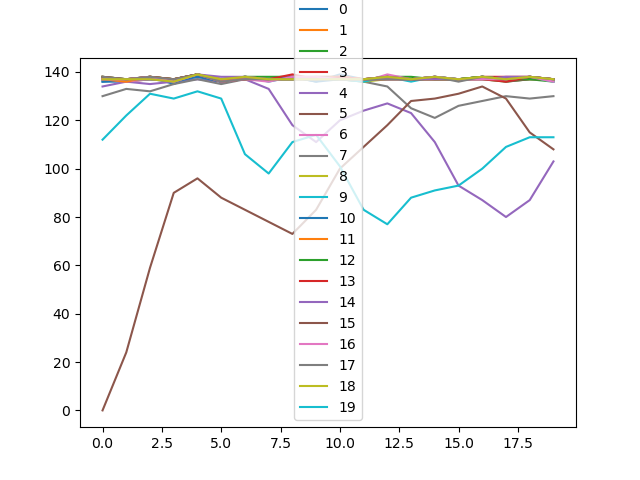

In [104]:
%matplotlib notebook
a.iloc[:20,:20].T.plot()
plt.show()

In [96]:
a.iloc[b[:10].index]

0    1    2    3    4    5    6    7    8    9  ...  1491  1492  1493  \
0  136  136  138  135  139  137  137  137  138  136  ...   137   138   137   
1  138  137  138  137  139  137  137  137  137  138  ...   136   138   137   
2  137  137  137  137  139  137  138  138  138  137  ...   137   137   137   
3  137  137  138  137  139  136  138  137  138  137  ...   131   133   135   
4  134  136  135  136  137  136  137  133  118  111  ...   137   138   137   
5  137  136  137  137  138  137  138  137  138  138  ...   137   138   137   
6  137  136  137  137  139  137  137  137  138  137  ...   137   138   137   
7  130  133  132  135  137  135  137  137  137  137  ...   136   137   137   
8  137  137  138  136  139  137  138  137  138  137  ...   137   138   137   
9  138  137  138  137  139  136  138  136  138  137  ...   136   138   137   

   1494  1495  1496  1497  1498  1499  \
0   138   137   137   136   138   137   
1   138   137   138   137   137   137   
2   138   137   137   137   137   136   
3   136   128   118   116   123   123   
4   138   137   137   136   137   137   
5   138   137   138   137   138   136   
6   137   137   138   136   138   136   
7   137   128   115   113   122   122   
8   138   137   137   137   138   137   
9   137   136   138   137   138   137   

                                       peakLocations  
0  [4, 140, 286, 308, 450, 490, 548, 614, 626, 66...  
1  [4, 26, 44, 112, 120, 210, 598, 776, 810, 876,...  
2  [4, 46, 80, 278, 388, 470, 490, 1204, 1318, 14...  
3  [4, 112, 138, 273, 536, 714, 729, 804, 873, 88...  
4  [4, 12, 34, 51, 60, 76, 84, 92, 100, 106, 113,...  
5  [4, 39, 60, 114, 124, 200, 424, 496, 508, 926,...  
6  [4, 288, 532, 566, 572, 706, 816, 848, 874, 93...  
7  [4, 26, 34, 48, 60, 66, 75, 80, 86, 95, 108, 1...  
8  [4, 112, 132, 148, 364, 371, 544, 612, 866, 87...  
9  [4, 204, 276, 322, 390, 494, 654, 1176, 1306, ...  

[10 rows x 1501 columns]

In [88]:
b.index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
            68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
            85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
           dtype='int64')

In [86]:
b[b.columns[:500]].apply(pkDetect, args = (2, 2), axis = 1)

0                               [4, 140, 286, 308, 450]
1                            [4, 26, 44, 112, 120, 210]
2                            [4, 46, 80, 278, 388, 470]
3                                    [4, 112, 138, 273]
4     [4, 12, 34, 51, 60, 76, 84, 92, 100, 106, 113,...
                            ...                        
95    [4, 12, 22, 32, 43, 47, 52, 68, 72, 77, 81, 96...
96                    [4, 8, 30, 82, 90, 124, 252, 354]
97                                          [4, 14, 28]
98    [4, 11, 17, 24, 32, 42, 48, 57, 67, 79, 96, 10...
99                                             [4, 358]
Length: 100, dtype: object

In [59]:
dfPulses

0       1       2       3       4       5       6       7       8       \
0        136     138     137     137     134     137     137     130     137   
1        136     137     137     137     136     136     136     133     137   
2        138     138     137     138     135     137     137     132     138   
3        135     137     137     137     136     137     137     135     136   
4        139     139     139     139     137     138     139     137     139   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
1495     137     137     137     128     137     137     137     128     137   
1496     137     138     137     118     137     138     138     115     137   
1497     136     137     137     116     136     137     136     113     137   
1498     138     137     137     123     137     138     138     122     138   
1499     137     137     136     123     137     136     136     122     137   

      9       ...  165900  165901  165902  165903  165904  165905  165906  \
0        138  ...     137     138     136     138     137     138     136   
1        137  ...     137     137     136     137     137     137     136   
2        138  ...     137     138     136     138     138     138     136   
3        137  ...     137     137     136     138     138     137     136   
4        139  ...     138     139     138     139     139     139     138   
...      ...  ...     ...     ...     ...     ...     ...     ...     ...   
1495     136  ...     137     137     137     137     137     137     136   
1496     138  ...     138     138     137     138     138     137     137   
1497     137  ...     137     136     137     137     137     137     136   
1498     138  ...     138     138     138     138     138     138     137   
1499     137  ...     137     137     137     137     136     137     137   

      165907  165908  165909  
0        138     137     107  
1        137     137     108  
2        138     137     114  
3        137     136     117  
4        139     138     121  
...      ...     ...     ...  
1495     137     137     137  
1496     138     138     137  
1497     137     137     137  
1498     137     138     138  
1499     137     137     137  

[1500 rows x 165910 columns]

In [13]:
dfPulses.to_csv("../PeakDetection_Na22_IndividualPulses2kV_v4_t100_nopb.csv")

<IPython.core.display.Javascript object>


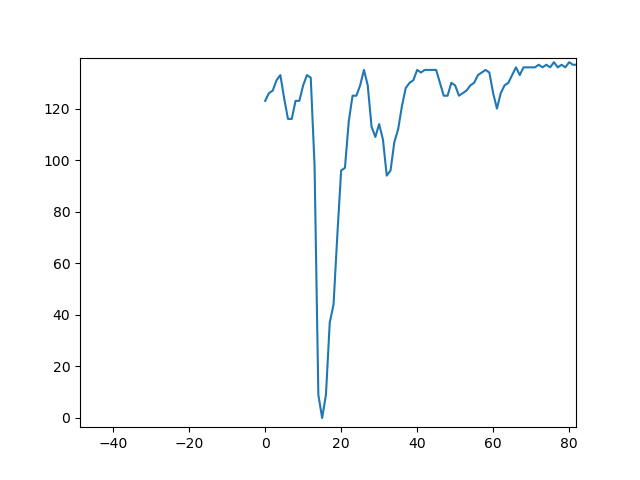

In [56]:
%matplotlib notebook

nPlots = 1
startIndex = 115


ax = plt.plot(dfPulses[dfPulses.columns[startIndex]])

for i in range(nPlots - 1):
    plt.plot(dfPulses[dfPulses.columns[startIndex + 1 + i]])
    plt.plot()

In [14]:
def singlePulseToArea(singlePulse):
    newPulse = max(singlePulse) - singlePulse
    return sum(newPulse)

In [15]:
dfAreas = pd.DataFrame(columns = ["Na22"])

In [16]:
dfAreas["Na22"] = dfPulses.apply(singlePulseToArea, axis = 0)

In [17]:
dfAreas

Na22
0        3054
1        2707
2        2731
3       21195
4        7373
...       ...
165905   2513
165906   3771
165907   2532
165908   2498
165909   9764

[165910 rows x 1 columns]

In [18]:
dfAreas.to_csv("../PeakDetection_Na22_Areas_2kV_v4_t100_nopb.csv")

In [19]:
dfAreasCalibrated = dfAreas*0.04227 - 25.74
# dfAreasCalibrated = dfAreas*0.03671 - 25.74

<IPython.core.display.Javascript object>


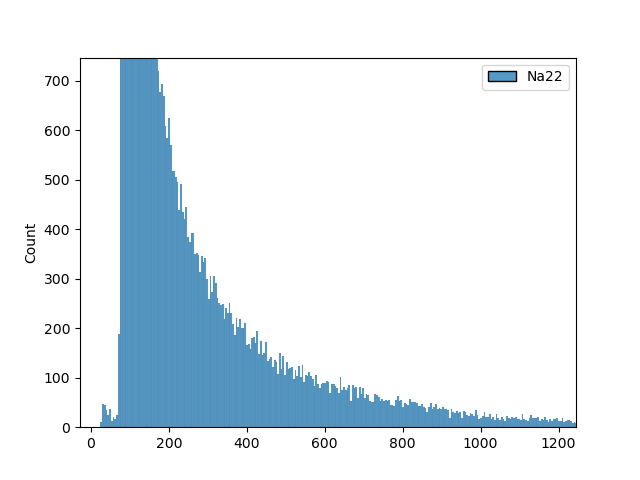

In [53]:
%matplotlib notebook
sns.histplot(dfAreasCalibrated, bins = 1500)
plt.show()

# Analysis of multiple sources spectra

In [34]:
dfAreasCo60 = pd.read_csv("../PeakDetection_Co60_Areas_2kV_v4_t100.csv", index_col = 0)

In [35]:
dfAreasCs137 = pd.read_csv("../PeakDetection_Cs137_Areas_2kV_v4_t100.csv", index_col = 0)

In [36]:
dfAreasNa22 = pd.read_csv("../PeakDetection_Na22_Areas_2kV_v4_t100.csv", index_col = 0)

In [37]:
dfAreasNa22NoPb = pd.read_csv("../PeakDetection_Na22_Areas_2kV_v4_t100_nopb.csv", index_col = 0)

In [38]:
dfAreasCo60

Co60
0       13942
1        1925
2        7308
3        1296
4        2755
...       ...
152903   1967
152904   2358
152905   2152
152906   1674
152907   2979

[152908 rows x 1 columns]

In [39]:
dfAreasCs137

Cs137
0       16273
1        4309
2        1555
3        1453
4        1437
...       ...
159046  16847
159047   9726
159048   3307
159049   1318
159050   3353

[159051 rows x 1 columns]

In [40]:
dfAreasNa22

Na22
0        3211
1       16913
2        2564
3        2771
4        2791
...       ...
157034   7409
157035   2856
157036   2602
157037   2823
157038   2713

[157039 rows x 1 columns]

In [41]:
dfAreasNa22NoPb = dfAreasNa22NoPb.rename(columns={"Na22": "Na22NoPb"})

In [42]:
#Make sure there's the same amount of data from each dataset
# dfAreasCs137 = dfAreasCs137[:len(dfAreasCo60)]
# dfAreasNa22 = dfAreasNa22[:len(dfAreasCo60)]

In [43]:
dfAreasCs137 = dfAreasCs137[:len(dfAreasCo60)]
dfAreasNa22 = dfAreasNa22[:len(dfAreasCo60)]
dfAreasCo60 = dfAreasCo60[:len(dfAreasCo60)]
dfAreasNa22NoPb = dfAreasNa22NoPb[:len(dfAreasCo60)]

In [44]:
# dfAreasCs137 = dfAreasCs137.loc[((dfAreasCs137["Cs137"] < 45000) & (dfAreasCs137["Cs137"] > 10000))]
# dfAreasCo60 = dfAreasCo60.loc[((dfAreasCo60["Co60"] < 45000) & (dfAreasCo60["Co60"] > 10000))]
# dfAreasNa22 = dfAreasNa22.loc[((dfAreasNa22["Na22"] < 45000) & (dfAreasNa22["Na22"] > 10000))]

In [45]:
# dfAreasCs137Calibrated = dfAreasCs137*0.04227 - 25.74
# dfAreasCo60Calibrated  = dfAreasCo60*0.04227 - 25.74
# dfAreasNa22Calibrated  = dfAreasNa22*0.04227 - 25.74
# dfAreasNa22NoPbCalibrated = dfAreasNa22NoPb*0.04227 - 25.74
# dfAreasCs137Calibrated = dfAreasCs137*0.03671 - 14.7
# dfAreasCo60Calibrated  = dfAreasCo60*0.03671 - 14.7
# dfAreasNa22Calibrated  = dfAreasNa22*0.03671 - 14.7
# dfAreasNa22NoPbCalibrated = dfAreasNa22NoPb*0.03671 - 14.7
dfAreasCs137Calibrated = dfAreasCs137*0.037 - 15
dfAreasCo60Calibrated  = dfAreasCo60*0.037 - 15
dfAreasNa22Calibrated  = dfAreasNa22*0.037 - 15
dfAreasNa22NoPbCalibrated = dfAreasNa22NoPb*0.037 - 15

In [46]:
dfAreasCs137Calibrated = dfAreasCs137Calibrated.loc[dfAreasCs137Calibrated["Cs137"] < 2000]
dfAreasCo60Calibrated = dfAreasCo60Calibrated.loc[dfAreasCo60Calibrated["Co60"] < 2000]
dfAreasNa22Calibrated = dfAreasNa22Calibrated.loc[dfAreasNa22Calibrated["Na22"] < 2000]
dfAreasNa22NoPbCalibrated = dfAreasNa22NoPbCalibrated.loc[dfAreasNa22NoPbCalibrated["Na22NoPb"] < 2000]

<IPython.core.display.Javascript object>


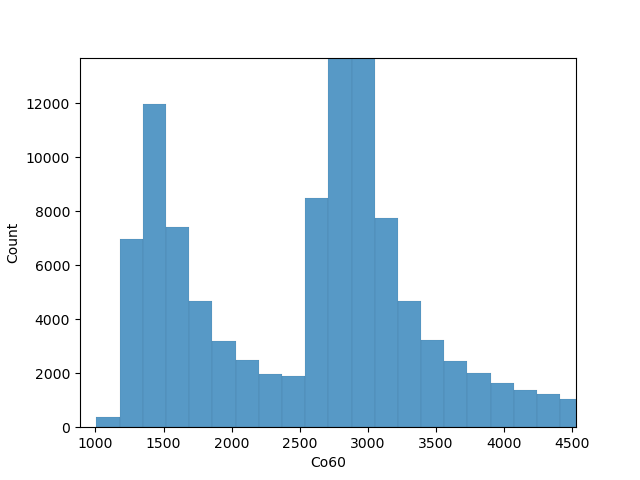

In [401]:
import seaborn as sns
import matplotlib

%matplotlib notebook

# sns.histplot(data = [dfAreasNa22NoPbCalibrated["Na22NoPb"], dfAreasNa22Calibrated["Na22"], dfAreasCo60Calibrated["Co60"], dfAreasCs137Calibrated["Cs137"]], alpha = 0.75, bins = 1000)
# sns.histplot(data = [dfAreasNa22Calibrated["Na22"], dfAreasCo60Calibrated["Co60"], dfAreasCs137Calibrated["Cs137"]], alpha = 0.75, bins = 1000)
# sns.histplot(data = [dfAreasNa22NoPb["Na22NoPb"], dfAreasNa22["Na22"], dfAreasCo60["Co60"], dfAreasCs137["Cs137"]], alpha = 0.75, bins = 1000)
sns.histplot(dfAreasCo60["Co60"], alpha = 0.75, bins = 1000)


plt.show()

# New baseline removal algorithm tests

In [449]:
dfAreasCo60v2 = pd.read_csv("../PeakDetection_test_Co60_Areas.csv", index_col = 0)

In [450]:
dfAreasCo60v2

Co60
50       9323
62       6910
74       5504
82      12216
94      16741
...       ...
267316   1990
267344   2648
267362    978
267432  13034
267484  18357

[20732 rows x 1 columns]

<IPython.core.display.Javascript object>


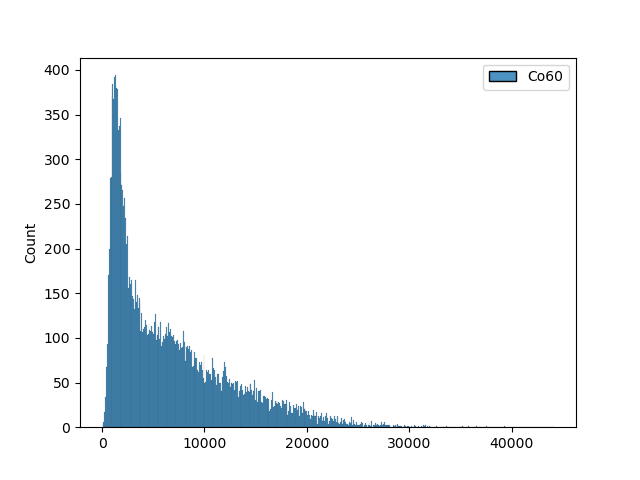

In [451]:
import seaborn as sns
import matplotlib

%matplotlib notebook

sns.histplot(data = dfAreasCo60v2, alpha = 0.8, bins = 500)

plt.show()

In [452]:
dfAreasCs137v2 = pd.read_csv("../PeakDetection_test_Cs137_Areas.csv", index_col = 0)

In [453]:
dfAreasCs137v2

Cs137
20      13896
30        810
49        303
63      14947
64      15860
...       ...
302597  17820
302601  17176
302606    907
302609  16780
302615   5646

[42986 rows x 1 columns]

<IPython.core.display.Javascript object>


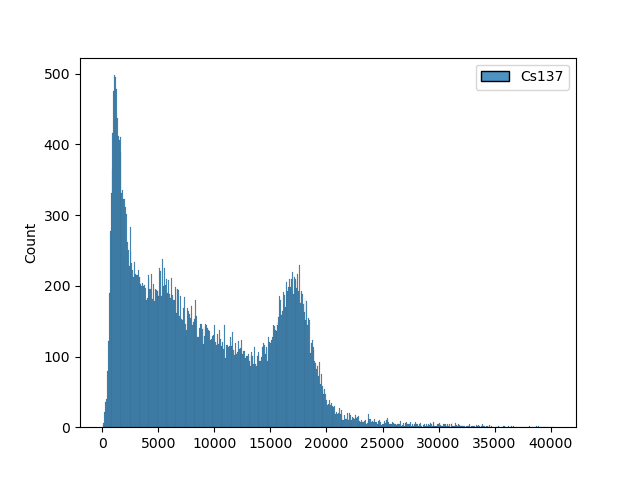

In [454]:
import seaborn as sns
import matplotlib

%matplotlib notebook

sns.histplot(data = dfAreasCs137v2, alpha = 0.8, bins = 500)

plt.show()

In [455]:
dfAreasNa22v2 = pd.read_csv("../PeakDetection_test_Na22_Areas.csv", index_col = 0)

In [456]:
dfAreasNa22v2

Na22
1      7424
2      1634
3      8869
9      7310
13     6935
...     ...
9907  13482
9911  14505
9912   3791
9915  14537
9919  17652

[2781 rows x 1 columns]

<IPython.core.display.Javascript object>


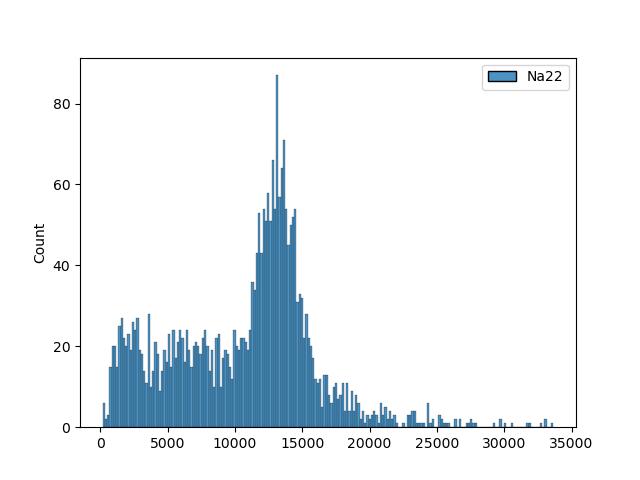

In [457]:
import seaborn as sns
import matplotlib

%matplotlib notebook

sns.histplot(data = dfAreasNa22v2, alpha = 0.8, bins = 200)

plt.show()

In [514]:
dfAreasCs137v2Calibrated = dfAreasCs137v2[:len(dfAreasNa22v2)]
dfAreasCo60v2Calibrated = dfAreasCo60v2[:len(dfAreasNa22v2)]
dfAreasNa22v2Calibrated = dfAreasNa22v2.copy()

a = 0.04227
b = -25.74

a = 0.0415
b = -17.7

dfAreasCs137v2Calibrated = dfAreasCs137v2Calibrated*a + b
dfAreasCo60v2Calibrated = dfAreasCo60v2Calibrated*a + b
dfAreasNa22v2Calibrated = dfAreasNa22v2Calibrated*a + b

<IPython.core.display.Javascript object>


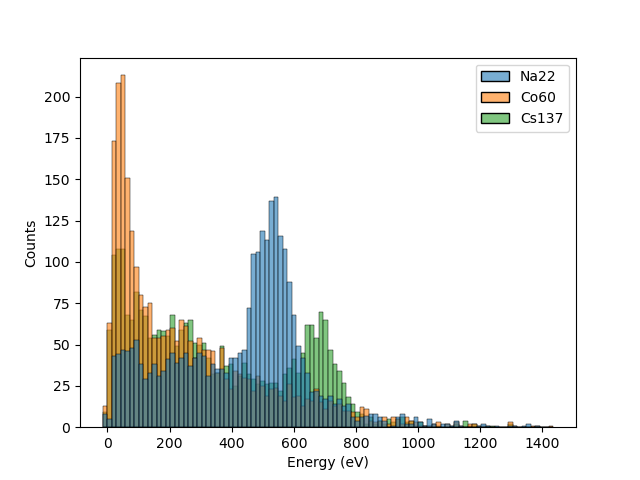

In [527]:
%matplotlib notebook


sns.histplot(data = [dfAreasNa22v2Calibrated["Na22"], dfAreasCo60v2Calibrated["Co60"], dfAreasCs137v2Calibrated["Cs137"]], alpha = 0.6, bins = 100)
plt.xlabel("Energy (eV)")
plt.ylabel("Counts")


plt.show()

## Individual pulses

In [529]:
dfCo60v2 = pd.read_csv("../PeakDetection_test_Co60.csv", index_col = 0)

In [530]:
dfCo60v2

0  1  2  3  4  5  6  7  8  9  ...  1491  1492  1493  1494  1495  1496  \
50      0  0  0  1  0  0  0  0  0  0  ...     0     0     0     0     0     0   
62      0 -1  0  0  0  0  0  0  0  0  ...    31    37    26    18    15    20   
74      0  0  0  0  1  0  0  0  0  0  ...     0     0     0     0     0     0   
82      0  0  0  0  0  0  0  0  0  0  ...     0     0     1     0     0     0   
94      0  0  0  1  0  0  0  0  0  0  ...    12     9     9    15    22    18   
...    .. .. .. .. .. .. .. .. .. ..  ...   ...   ...   ...   ...   ...   ...   
267316  0 -1  0  0  0  0  0  0  0 -1  ...     1     2     0     0     0     0   
267344  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
267362  0  0  0  0  0  0  0  0 -1  0  ...     0     0     0     0     0     0   
267432  0 -1  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
267484  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   

        1497  1498  1499                                      peakLocations  
50         0     0     0  [6, 14, 18, 27, 33, 39, 42, 46, 55, 70, 88, 94...  
62        23    26    17  [4, 69, 108, 164, 197, 201, 237, 249, 287, 313...  
74         1     0     1  [-2, 5, 12, 15, 28, 31, 43, 51, 58, 66, 69, 75...  
82         0     0     0  [5, 17, 27, 35, 45, 52, 63, 68, 74, 81, 85, 92...  
94        11    10     6  [4, 11, 21, 32, 38, 43, 47, 54, 64, 73, 82, 95...  
...      ...   ...   ...                                                ...  
267316     0     0     0  [6, 29, 98, 107, 129, 174, 178, 199, 230, 345,...  
267344     0     0     0  [4, 13, 23, 37, 46, 57, 76, 102, 108, 123, 139...  
267362     0     0     0  [4, 42, 46, 56, 81, 138, 331, 498, 526, 729, 1...  
267432     0     0     0  [5, 175, 182, 185, 190, 197, 204, 208, 221, 22...  
267484     0     0     0  [4, 12, 23, 28, 40, 46, 55, 68, 73, 79, 84, 87...  

[20732 rows x 1501 columns]

<IPython.core.display.Javascript object>


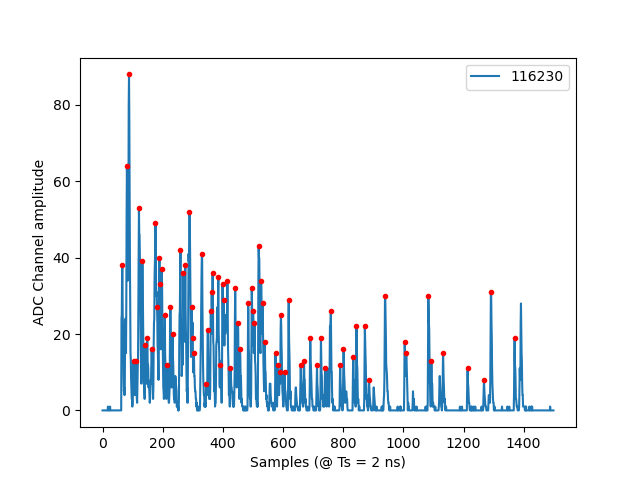

In [499]:
import random
pulsesToPlot = 1
currentPlot = random.randrange(len(dfCo60v2))


%matplotlib notebook

peaks = dfCo60v2.iloc[currentPlot:currentPlot + pulsesToPlot, -1].values[0].replace("[", "").replace("]", "").replace("\n", "").split(",")
a = []
for i in peaks:
    a.append(int(i) + 60)
peaks = a
# peaks

trace = dfCo60v2.iloc[currentPlot:currentPlot + pulsesToPlot ,:PMT_PULSE_LENGTH].T

trace.plot()
plt.plot(peaks, trace.values[peaks], 'r.')
plt.xlabel("Samples (@ Ts = 2 ns)")
plt.ylabel("ADC Channel amplitude")

plt.show()

### Cs137

In [531]:
dfCs137v2 = pd.read_csv("../PeakDetection_test_Cs137.csv", index_col = 0)

In [532]:
dfCs137v2

0  1  2  3  4  5  6  7  8  9  ...  1491  1492  1493  1494  1495  1496  \
20      0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
30      0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     6    14   
49      0  0  0  0  0  0  0  0  0  0  ...     0     0    -1     0     0     0   
63      0  0  0  0  0  0  0  0  0  0  ...     0     0     0     1     0     0   
64      0  0  0  0  0  0  0  0  0  0  ...    -1     0     0     0     0     0   
...    .. .. .. .. .. .. .. .. .. ..  ...   ...   ...   ...   ...   ...   ...   
302597  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
302601  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
302606  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
302609  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
302615  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   

        1497  1498  1499                                      peakLocations  
20         0     0     0  [5, 20, 35, 39, 44, 53, 57, 63, 68, 72, 78, 82...  
30        15     8     9  [4, 16, 29, 38, 190, 237, 478, 508, 543, 938, ...  
49         0     0     0                        [4, 58, 116, 159, 194, 210]  
63         0     0     0  [6, 19, 29, 34, 39, 48, 53, 61, 72, 76, 82, 86...  
64         0     0     0  [7, 18, 26, 34, 44, 51, 58, 62, 69, 75, 82, 88...  
...      ...   ...   ...                                                ...  
302597     0     0     0  [5, 14, 24, 33, 39, 45, 54, 58, 63, 76, 89, 97...  
302601     0     0     0  [4, 18, 22, 37, 56, 78, 82, 85, 89, 102, 107, ...  
302606     7     9     7  [4, 19, 26, 106, 127, 154, 207, 276, 342, 431,...  
302609     0     0     0  [5, 18, 21, 25, 35, 44, 55, 62, 68, 74, 78, 88...  
302615     0     0     0  [5, 20, 24, 35, 55, 62, 71, 75, 84, 96, 108, 1...  

[42986 rows x 1501 columns]

<IPython.core.display.Javascript object>


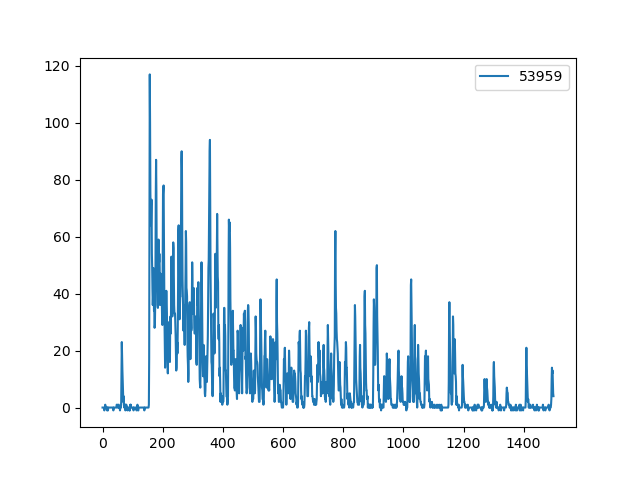

In [545]:
import random
pulsesToPlot = 1
currentPlot = random.randrange(len(dfCo60v2))


%matplotlib notebook

peaks = dfCs137v2.iloc[currentPlot:currentPlot + pulsesToPlot, -1].values[0].replace("[", "").replace("]", "").replace("\n", "").split(",")
a = []
for i in peaks:
    a.append(int(i) + 60)
peaks = a
peaks

trace = dfCs137v2.iloc[currentPlot:currentPlot + pulsesToPlot ,:PMT_PULSE_LENGTH].T

trace.plot()
# plt.plot(peaks, trace.values[peaks], 'r.')

plt.show()

### Na22

In [534]:
dfNa22v2 = pd.read_csv("../PeakDetection_test_Na22.csv", index_col = 0)

In [535]:
dfNa22v2

0  1  2  3  4  5  6  7  8  9  ...  1491  1492  1493  1494  1495  1496  \
1     0  0  0  0  1  0  1  0  0  0  ...     0     0     0     0     0     1   
2     1  0  0  0  1  0  1  0  1  0  ...     0     0     0     1     0     0   
3     0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
9     0  0  0  0  0  0  0  0  0  0  ...     1     0     0     0     1     0   
13    0  0  0  0  1  0  0  0  0  0  ...     0     0     0     0     0     0   
...  .. .. .. .. .. .. .. .. .. ..  ...   ...   ...   ...   ...   ...   ...   
9907  0  0  0  0  1  0  0  0  0  0  ...    11     9     4     2     3     1   
9911  0  0  1  0  1  0  0  0  1  0  ...     0     1     0     1     0     0   
9912  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     1   
9915  0  1 -1  0  0  1 -1  0 -1  1  ...     1    -1     0    -1     0    -1   
9919  0  0  0  0  1  0  0  0  1  0  ...     0     1     6    11     0     1   

      1497  1498  1499                                      peakLocations  
1        0     0     0  [6, 14, 31, 41, 45, 50, 63, 76, 88, 94, 99, 10...  
2        0     0     0  [4, 12, 83, 114, 143, 175, 253, 437, 538, 661,...  
3        0     0     0  [6, 14, 22, 33, 42, 51, 62, 67, 72, 84, 95, 10...  
9        1     0     1  [11, 23, 39, 50, 58, 89, 102, 108, 113, 119, 1...  
13       0     0     0  [5, 8, 11, 15, 28, 42, 48, 66, 71, 98, 126, 13...  
...    ...   ...   ...                                                ...  
9907     0     1     0  [6, 13, 20, 27, 37, 40, 48, 57, 80, 89, 93, 96...  
9911     0     0     0  [4, 42, 49, 64, 92, 123, 184, 191, 289, 293, 3...  
9912     0     0     0  [6, 24, 28, 37, 46, 66, 70, 80, 113, 139, 193,...  
9915     0     1     9  [5, 8, 14, 28, 35, 44, 48, 57, 63, 72, 83, 89,...  
9919     0     0     0  [5, 8, 14, 23, 36, 42, 59, 68, 71, 78, 94, 103...  

[2781 rows x 1501 columns]

<IPython.core.display.Javascript object>


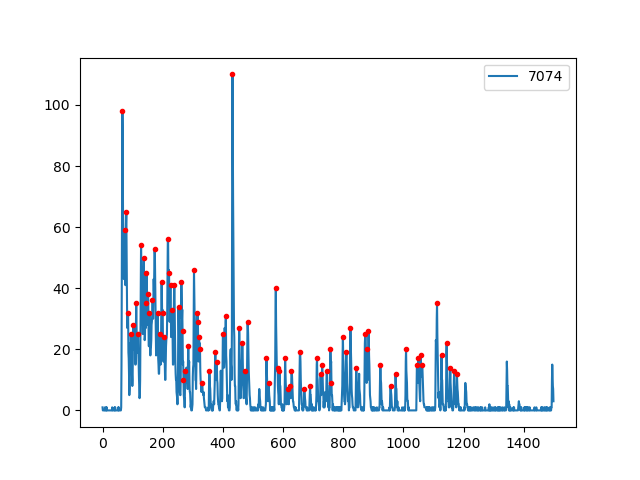

In [543]:
import random
pulsesToPlot = 1
currentPlot = random.randrange(len(dfNa22v2))


%matplotlib notebook

peaks = dfNa22v2.iloc[currentPlot:currentPlot + pulsesToPlot, -1].values[0].replace("[", "").replace("]", "").replace("\n", "").split(",")
a = []
for i in peaks:
    a.append(int(i) + 60)
peaks = a
peaks

trace = dfNa22v2.iloc[currentPlot:currentPlot + pulsesToPlot ,:PMT_PULSE_LENGTH].T

trace.plot()
plt.plot(peaks, trace.values[peaks], 'r.')

plt.show()